In [25]:
%pylab inline
import pandas as pd

import torch
import torch.nn as nn

from datasets.cmnist import make_joint_distribution
from utils.distribution import DiscreteDistribution, compute_ce, compute_kl
from models.training import train
from models.encoders import DiscreteEncoder

from models.criteria import InformationBottleneckCriterion, IndependenceCriterion, SufficiencyCriterion, SeparationCriterion

Populating the interactive namespace from numpy and matplotlib


# CMNIST data distribution

In [102]:
# Create the joint distribution for y-CMNIST (CMNIST or d-CMNIST are also available)
dist = make_joint_distribution('y-CMNIST')

print('Joint distribution: %s' %dist)

Joint distribution: p(y,e,d,x,c,t)


In [103]:
# Create the training distribution by selecting t=1 and marginalizing d and c
train_dist = dist.condition_on('t',1)

# Create the test distribution by selecting t=0 and marginalizing d, c and e
test_dist = dist.condition_on('t',0)

print('Train distribution: %s' %train_dist)
print('Test distribution: %s' %test_dist)

Train distribution: p(y,e,d,x,c|t=1)
Test distribution: p(y,e,d,x,c|t=0)


In [104]:
# Compute the amout of distribution shift I(xy;t)
print('Distribution shift: %f nats' %(dist.compute('I(x,y;t)')))

# Compute the amout of concept shift I(y;t|x)
print('Concept shift: %f nats' %(dist.compute('I(y;t|x)')))

# Compute the amout of concept shift I(x;t)
print('Covariate shift: %f nats' %(dist.compute('I(x;t)')))

Distribution shift: 0.306607 nats
Concept shift: 0.237813 nats
Covariate shift: 0.068793 nats


In [105]:
# Consider a model q(y|x) that matches the train distribution p(y|x,t=1)
q_y_x = train_dist.conditional('y','x')
print('q(y|x)=%s' % q_y_x)

# Compute the OOD error for q(y|x): KL(p(y|x,t=0)||q(y|x))
ood_error = compute_kl(test_dist, q_y_x)
print('OOD error: %f nats' % ood_error)

q(y|x)=p(y|x,t=1)
OOD error: 1.249681 nats


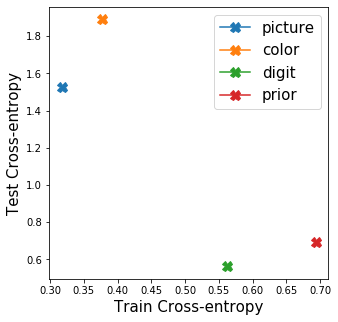

In [106]:
# compute and plot train and OOD cross-entropy for models that use picures 'x', color 'c', digit 'd'
def plot_default():
    f, ax = plt.subplots(1,1,figsize=(5,5))
    for variable, label in [('x','picture'),('c','color'),('d','digit')]:
        train_ce = compute_ce(train_dist, train_dist.conditional('y', variable))
        ood_ce = compute_ce(test_dist, train_dist.conditional('y', variable))
        ax.plot(train_ce, ood_ce, marker='X', markersize=10, label=label)


    # and prior information
    train_ce = compute_ce(train_dist, train_dist.marginal('y'))
    ood_ce = compute_ce(test_dist, train_dist.marginal('y'))
    ax.plot(train_ce, ood_ce, marker='X', markersize=10, label='prior')

    ax.set_xlabel('Train Cross-entropy', fontsize=15)
    ax.set_ylabel('Test Cross-entropy', fontsize=15);
    
plot_default()
plt.legend(fontsize=15)

# Model Training

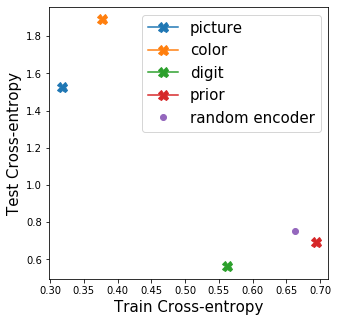

In [113]:
# Create an encoder which maps each 'x' into a latent 'z' which consists of 64 different values
encoder = DiscreteEncoder(z_dim=64)

# Compute the predictive distribution p(y|z,t=1) induced by the encoder
q_y_z = encoder(train_dist).conditional('y','z')

# Compute and visualize the train and ood cross-entropy for the model with random initialization
train_ce = compute_ce(encoder(train_dist),q_y_z).item()
ood_ce = compute_ce(encoder(test_dist),q_y_z).item()

plot_default()
plt.plot(train_ce,ood_ce, 'o', label='random encoder')

plt.legend(fontsize=15)

In [114]:
# Use the Separation criterion for training. 
# SufficiencyCriterion, SeparationCriterion and InformationBottleneckCriterion are also available
criterion = SeparationCriterion(reg=1e6)

# Train until convergence 
logs = train(encoder, criterion, train_dist.marginal(['x','y','e']), test_dist.marginal(['x','y']), verbose=True)


Distance: 0.000248>0.000100



Distance: 0.000447>0.000100



Distance: 0.000836>0.000100



Distance: 0.001746>0.000100



Distance: 0.004212>0.000100



Distance: 0.009528>0.000100



Distance: 0.018450>0.000100



Distance: 0.030021>0.000100



Distance: 0.033504>0.000100



Distance: 0.026831>0.000100



Distance: 0.018402>0.000100



Distance: 0.011684>0.000100



Distance: 0.007395>0.000100



Distance: 0.004718>0.000100



Distance: 0.003068>0.000100



Distance: 0.002022>0.000100



Distance: 0.001324>0.000100



Distance: 0.000892>0.000100



Distance: 0.000584>0.000100



Distance: 0.000386>0.000100



Distance: 0.000256>0.000100



Distance: 0.000171>0.000100



Distance: 0.000112>0.000100



Done


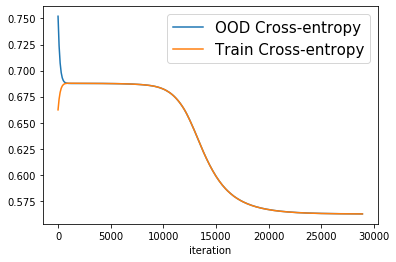

In [115]:
# Visualize train and OOD cross-entropy over the training iterations
logs = pd.DataFrame(logs)
logs.plot(x='iteration')
plt.legend(fontsize=15)

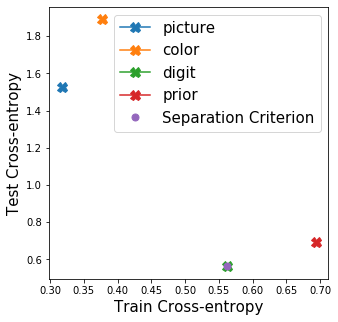

In [116]:
# Compute and visualize the train and ood cross-entropy for the model after training
q_y_z = encoder(train_dist).conditional('y','z')

sep_train_ce = compute_ce(encoder(train_dist),q_y_z).item()
sep_ood_ce = compute_ce(encoder(test_dist),q_y_z).item()

plot_default()
plt.plot(sep_train_ce, sep_ood_ce, 'o', markersize=7, label='Separation Criterion')

plt.legend(fontsize=15);

In [117]:
# Re-initialize the encoder 
encoder = DiscreteEncoder(z_dim=64)

# And train it using the SufficiencyCriterion
criterion = SufficiencyCriterion(reg=1e6)

# Train until convergence 
logs = train(encoder, criterion, train_dist.marginal(['x','y','e']), test_dist.marginal(['x','y']), verbose=True)


Distance: 0.008814>0.000100



Distance: 0.003305>0.000100



Distance: 0.001095>0.000100



Distance: 0.001039>0.000100



Distance: 0.000422>0.000100



Distance: 0.000198>0.000100



Distance: 0.000107>0.000100



Done


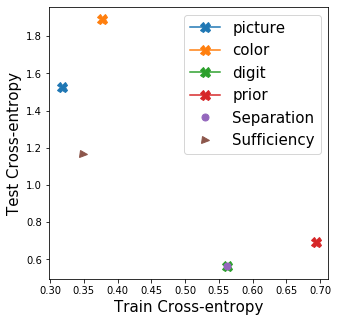

In [119]:
# Compute and visualize the train and ood cross-entropy for the model after training
q_y_z = encoder(train_dist).conditional('y','z')

suff_train_ce = compute_ce(encoder(train_dist),q_y_z).item()
suff_ood_ce = compute_ce(encoder(test_dist),q_y_z).item()

plot_default()
plt.plot(sep_train_ce, sep_ood_ce, 'o', markersize=7, label='Separation')
plt.plot(suff_train_ce, suff_ood_ce, '>', markersize=7, label='Sufficiency')


plt.legend(fontsize=15);